# Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
pd.set_option('display.max_colwidth', None)
from tqdm.auto import tqdm
import pickle
import random
import re
import math
import os
import json
import collections
from collections import Counter
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import pickle

# Mở file .pkl ở chế độ đọc nhị phân
with open('/content/drive/MyDrive/EfficientNet_v2/vocabulary_data.pkl', 'rb') as f:
    # Đọc dữ liệu từ file và gán vào một biến
    data = pickle.load(f)

# Sử dụng dữ liệu đã đọc
w2i = data['word_to_idx']
i2w = data['idx_to_word']
wd = data['world_dict']
print(wd)
print(len(w2i))
s = w2i['<start>']
e = w2i['<end>']
p = w2i['<pad>']
print(s, e, p)

['<pad>', '<start>', '<end>', 'có', 'một', 'đang', 'người', 'hiện', 'xuất', 'trên', 'hàng', 'của', 'bên', 'trong', 'nhiều', 'những', 'chiếc', 'trước', 'nữ', 'áo', 'phụ', 'mặc', 'màu', 'được', 'gái', 'cô', 'đứng', 'xe', 'đường', 'phía', 'hai', 'sự', 'khu', 'nhà', 'ông', 'đàn', 'bức', 'là', 'cửa', 'ảnh', 'quầy', 'cái', 'con', 'cây', 'mặt', 'bày', 'vài', 'tay', 'di', 'bán', 'hình', 'đây', 'ngồi', 'xanh', 'máy', 'khung', 'và', 'chuyển', 'trắng', 'ngôi', 'đồ', 'chợ', 'cảnh', 'đi', 'chụp', 'thị', 'siêu', 'các', 'nhóm', 'đỏ', 'ăn', 'kệ', 'này', 'cầm', 'đen', 'phố', 'quả', 'lá', 'nhau', 'vào', 'trang', 'hoa', 'căn', 'tấm', 'trưng', 'vực', 'toà', 'rau', 'vàng', 'tường', 'biển', 'bàn', 'nước', 'đội', 'trái', 'sản', 'bộ', 'đeo', 'trí', 'cạnh', 'phẩm', 'sau', 'thuyền', 'loại', 'quán', 'thanh', 'quần', 'thông', 'đẩy', 'tranh', 'với', 'củ', 'cùng', 'quanh', 'nhìn', 'sông', 'ba', 'hè', 'cổng', 'đặt', 'phòng', 'ghế', 'đèn', 'vỉa', 'cổ', 'gần', 'giữa', 'nón', 'mua', 'treo', 'đôi', 'gian', 'bé', 'trai',

# Download dataset

## Define parameter

In [4]:
# The batch size is set to 64, meaning that 64 samples of data will be processed in one forward/backward pass of the network during training.
batch_size = 8

# The embedding size is set to 1280, meaning that each input sample will be represented by a vector of size 1280.
embedding_size = 1280

## Download image files

# Group all captions together having the same image ID.


In [5]:
PATH = '/content/drive/MyDrive/EfficientNet_v2/train-images/'
TEST_PATH = '/content/drive/MyDrive/EfficientNet_v2/public-test-images/'

In [6]:
annotation_file = '/content/drive/MyDrive/EfficientNet_v2/train_data.json'
annotation_test_file = '/content/drive/MyDrive/EfficientNet_v2/test_data.json'

In [7]:
import os

def change_image_extensions(folder_path):


    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpeg', '.png')):
            base_name, extension = os.path.splitext(filename)
            new_filename = base_name + '.jpg'
            os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_filename))
            print(f"Đã đổi tên {filename} thành {new_filename}")

In [8]:
change_image_extensions(PATH)
change_image_extensions(TEST_PATH)

In [9]:
import json


def remove_missing_image_captions(json_file_path, image_folder_path):

    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Tạo một list mới để lưu trữ các caption hợp lệ
    filtered_annotations = []

    for annotation in data['annotations']:
        image_id = annotation['image_id']
        image_path = os.path.join(image_folder_path, f'{image_id:011d}.jpg')

        # Kiểm tra xem file ảnh có tồn tại hay không
        if os.path.exists(image_path):
            filtered_annotations.append(annotation)

    # Cập nhật data['annotations'] với list mới
    data['annotations'] = filtered_annotations

    # Ghi lại file JSON đã được lọc
    with open(json_file_path, 'w') as f:
        json.dump(data, f, indent=4)

    print(f"Đã loại bỏ các caption không có file ảnh tương ứng. File JSON đã được cập nhật.")



In [10]:
remove_missing_image_captions(annotation_file, PATH)

Đã loại bỏ các caption không có file ảnh tương ứng. File JSON đã được cập nhật.


In [11]:
remove_missing_image_captions(annotation_test_file, TEST_PATH)

Đã loại bỏ các caption không có file ảnh tương ứng. File JSON đã được cập nhật.


In [12]:
# Loads three sets of data in the JSON format into Python variables.

# Defines the path to the file containing the training set annotations in JSON format.
annotation_file = '/content/drive/MyDrive/EfficientNet_v2/train_data.json'

# Opens the file at the specified path in read mode and assigns its contents to the file handle ‘f’
# Parse the contents of the file handle ‘f’ and load it into a Python dictionary called ‘annotations’
with open(annotation_file, 'r') as f:
    annotations = json.load(f)



annotation_test_file = '/content/drive/MyDrive/EfficientNet_v2/test_data.json'

with open(annotation_test_file, 'r') as f:
    annotations_test = json.load(f)

In [13]:
# Group all captions together having the same image ID.

# ‘image_path_to_caption’, where the keys are the file paths to the images and the values are lists of captions for each image
img_path_to_caption = collections.defaultdict(list)

# Iterates through the ‘annotations['annotations']’ list, which contains information about the captions for each image. For each caption,
# the code creates a string caption that starts with the special token ‘"<start>"’ and ends with the special token ‘"<end>"’.
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  img_path = PATH + '%011d.jpg' % (val['image_id'])
  img_path_to_caption[img_path].append(caption)

In [14]:
img_path_to_caption_test = collections.defaultdict(list)
for val in annotations_test['annotations']:
  caption = f"<start> {val['caption']} <end>"
  img_path = TEST_PATH + '%011d.jpg' % (val['image_id'])
  img_path_to_caption_test[img_path].append(caption)

# Convert to dataframe

In [15]:
df_train = (pd.DataFrame.from_dict(img_path_to_caption, orient='index').T.melt(var_name='image', value_name='caption')
            .dropna(subset=['caption']))


df_train.head()

,image,caption
0,/content/drive/MyDrive/EfficientNet_v2/train-images/00000000002.jpg,<start> ba chiếc thuyền đang di chuyển ở trên con sông <end>
1,/content/drive/MyDrive/EfficientNet_v2/train-images/00000000002.jpg,<start> có ba con thuyền đang di chuyển trên con sông <end>
2,/content/drive/MyDrive/EfficientNet_v2/train-images/00000000002.jpg,<start> trên dòng sông có ba con thuyền đang di chuyển <end>
3,/content/drive/MyDrive/EfficientNet_v2/train-images/00000000002.jpg,<start> ba con thuyền đang di chuyển bên một cánh đồng lúa <end>
4,/content/drive/MyDrive/EfficientNet_v2/train-images/00000000002.jpg,<start> ba chiếc thuyền đang chuyển động trên một con sông <end>


In [16]:
df_test_raw = (pd.DataFrame.from_dict(img_path_to_caption_test, orient='index').T.melt(var_name='image', value_name='caption')
          .dropna(subset=['caption']))
df_test_raw.head()

,image,caption
0,/content/drive/MyDrive/EfficientNet_v2/public-test-images/00000000001.jpg,<start> đây là khung cảnh xuất hiện ở phía trước một căn nhà <end>
1,/content/drive/MyDrive/EfficientNet_v2/public-test-images/00000000001.jpg,<start> có một căn nhà cao tầng xuất hiện ở trong bức ảnh <end>
2,/content/drive/MyDrive/EfficientNet_v2/public-test-images/00000000001.jpg,<start> ở trong bức ảnh có sự xuất hiện của một căn nhà cao tầng <end>
3,/content/drive/MyDrive/EfficientNet_v2/public-test-images/00000000001.jpg,<start> có một chiếc xe máy xuất hiện ở trong căn nhà <end>
4,/content/drive/MyDrive/EfficientNet_v2/public-test-images/00000000001.jpg,<start> đây là bức ảnh chụp ở phía trước của một căn nhà cao tầng <end>


# Import data

In [17]:
cap = df_train
print(len(cap))

18835


## Show image

In [18]:
import cv2
import glob
figure = plt.figure(figsize=(20, 20))
for i in range(10):
  plt.subplot(5, 2, i+1)
  idx = np.random.randint(0, 1000)
  images = cv2.imread(cap['image'].iloc[idx])
  plt.imshow(cv2.cvtColor(images, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title(df_train['caption'].iloc[idx])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [19]:
def remove_1_length_word(x):
  list = []
  for i in x:
    if len(i)> 1:
      list.append(i)
  return list

In [20]:
# The function removes punctuation marks and digits from the input string and returns the processed string
def standardize(inputs):
  inputs = inputs.lower()
  inputs = re.sub(r'\.!?( *)', ' ', inputs)
  inputs = re.sub(r'[0 - 9]', ' ', inputs)

  return inputs

In [21]:
max_sequence_len = 35

In [22]:
# The function performs a series of operations to clean and preprocess the data in the data frame
def preprocess(df):
  df = df.copy()
  df['caption_clean'] = df['caption'].apply(standardize)
  df['caption_clean'] = df['caption_clean'].apply(lambda x:  [i.lower() for i in x.split(' ')] )
  df['caption_clean'] = df['caption_clean'].apply(remove_1_length_word)
  df['lens'] = df.caption_clean.apply(lambda x: len(x))
  pad = '<pad>'
  df['caption_clean'] = df.caption_clean.apply(lambda x: x + (max_sequence_len - len(x)) * [pad])
  df = df.drop(labels = 'lens', axis = 1)
  return df


In [23]:
df_all = preprocess(pd.concat([df_train, df_test_raw]))
df = preprocess(cap)
df_test = preprocess(df_test_raw)

## Create dictionary


In [24]:
world_dict = df_all['caption_clean'].apply(lambda x: ' '.join(x)).str.cat(sep = ' ').split(' ')
len(world_dict)

756875

In [25]:
world_dict = Counter(world_dict)
world_dict = sorted(world_dict, key = world_dict.get, reverse = True)
print(world_dict)
word_to_idx = {word:idx for (idx,word) in enumerate(world_dict)}
idx_to_word = {idx:word for (idx,word) in enumerate(world_dict)}
df['token'] = df['caption_clean'].apply(lambda x: [word_to_idx.get(i) for i in x])
df_test['token'] = df_test['caption_clean'].apply(lambda x: [word_to_idx.get(i) for i in x])

#vocab size
print(len(word_to_idx))
vocab_size = len(word_to_idx)

['<pad>', '<start>', '<end>', 'có', 'một', 'đang', 'người', 'hiện', 'xuất', 'trên', 'hàng', 'của', 'bên', 'trong', 'nhiều', 'những', 'chiếc', 'trước', 'nữ', 'áo', 'phụ', 'mặc', 'màu', 'được', 'gái', 'cô', 'đứng', 'xe', 'đường', 'phía', 'hai', 'sự', 'khu', 'nhà', 'ông', 'đàn', 'bức', 'là', 'cửa', 'ảnh', 'quầy', 'cái', 'con', 'cây', 'mặt', 'bày', 'vài', 'tay', 'di', 'bán', 'hình', 'đây', 'ngồi', 'xanh', 'máy', 'khung', 'và', 'chuyển', 'trắng', 'ngôi', 'đồ', 'chợ', 'cảnh', 'đi', 'chụp', 'thị', 'siêu', 'các', 'nhóm', 'đỏ', 'ăn', 'kệ', 'này', 'cầm', 'đen', 'phố', 'quả', 'lá', 'nhau', 'vào', 'trang', 'hoa', 'căn', 'tấm', 'trưng', 'vực', 'toà', 'rau', 'vàng', 'tường', 'biển', 'bàn', 'nước', 'đội', 'trái', 'sản', 'bộ', 'đeo', 'trí', 'cạnh', 'phẩm', 'sau', 'thuyền', 'loại', 'quán', 'thanh', 'quần', 'thông', 'đẩy', 'tranh', 'với', 'củ', 'cùng', 'quanh', 'nhìn', 'sông', 'ba', 'hè', 'cổng', 'đặt', 'phòng', 'ghế', 'đèn', 'vỉa', 'cổ', 'gần', 'giữa', 'nón', 'mua', 'treo', 'đôi', 'gian', 'bé', 'trai',

In [26]:
import pickle

In [27]:
with open('/content/drive/MyDrive/EfficientNet_v2/vocabulary_data.pkl', 'wb') as f:  # Specify the path where you want to save the file
    pickle.dump({'word_to_idx': word_to_idx, 'idx_to_word': idx_to_word, 'world_dict': world_dict}, f)

In [28]:
print(len(df))

18835


In [29]:
print(len(df_test))

2790


In [30]:
df.head(2)

,image,caption,caption_clean,token
0,/content/drive/MyDrive/EfficientNet_v2/train-images/00000000002.jpg,<start> ba chiếc thuyền đang di chuyển ở trên con sông <end>,"[<start>, ba, chiếc, thuyền, đang, di, chuyển, trên, con, sông, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 116, 16, 102, 5, 48, 57, 9, 42, 115, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,/content/drive/MyDrive/EfficientNet_v2/train-images/00000000002.jpg,<start> có ba con thuyền đang di chuyển trên con sông <end>,"[<start>, có, ba, con, thuyền, đang, di, chuyển, trên, con, sông, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 3, 116, 42, 102, 5, 48, 57, 9, 42, 115, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [31]:
# from sklearn.model_selection import train_test_split
# df = df.sort_values('image')
# train, test = train_test_split(df, random_state = 42, test_size = 0.2)
train = df
test = df_test
print(len(train), train['image'].nunique())
print(len(test), test['image'].nunique())

18835 3767
2790 558


# Image ==> EfficientNetV2 ==> {imagename : image_emb}

In [32]:
from PIL import Image
class extractFeatureEfficientNetV2():
  def __init__(self,data):
    self.data = data
    self.scaler = transforms.Resize([224, 224])
    self.normalizer = transforms.Normalize(
        mean  = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225])
    self.transform = transforms.ToTensor()
  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    # take image from file image_path
    # print('check 1 ')
    img_name = self.data.iloc[idx]['image']
    # print('check 2 ')
    img = Image.open(img_name).convert('RGB')
    img =  self.normalizer(self.transform((self.scaler(img))))
    if img.shape[0] == 1:
      print(img.shape)
    return img_name, img

# Extract Feature

In [33]:
train_unique_image = train[['image']].drop_duplicates()
# train_unique_image = train_unique_image[:1000]
train_extract = extractFeatureEfficientNetV2(train_unique_image)
train_loader = DataLoader(train_extract, batch_size = 1, shuffle = False)

test_unique_image = test[['image']].drop_duplicates()
# test_unique_image = test_unique_image[:1000]
test_extract = extractFeatureEfficientNetV2(test_unique_image)
test_loader = DataLoader(test_extract, batch_size = 1, shuffle = False)

In [34]:
for (image_name, img) in train_loader:
    print(image_name)
    print(img.shape)
    break

('/content/drive/MyDrive/EfficientNet_v2/train-images/00000000002.jpg',)
torch.Size([1, 3, 224, 224])


In [35]:
train_unique_image.head() #du lieu idx va image name

,image
0,/content/drive/MyDrive/EfficientNet_v2/train-images/00000000002.jpg
5,/content/drive/MyDrive/EfficientNet_v2/train-images/00000000003.jpg
10,/content/drive/MyDrive/EfficientNet_v2/train-images/00000000004.jpg
15,/content/drive/MyDrive/EfficientNet_v2/train-images/00000000005.jpg
20,/content/drive/MyDrive/EfficientNet_v2/train-images/00000000006.jpg


# EfficientNetV2 model


In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_img = torchvision.models.efficientnet_v2_s(weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 104MB/s]


In [37]:
model_img.eval()
model_img_layer_4 = model_img._modules.get('features')#[0:-1]
print(model_img_layer_4)
class fine_tune_model(nn.Module):
    def __init__(self, model_img_layer_4):
        super(fine_tune_model, self).__init__()
        self.model_img_layer_4 = model_img_layer_4
        self.conv = nn.LazyConv2d(512, 1, padding='same')
    def forward(self, x):
        x = self.model_img_layer_4(x)
        x = self.conv(x)
        return x
EfficientNet_V2_layer_4 = fine_tune_model(model_img_layer_4).to(device)

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.0, mode=row)
    )
    (1): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
      )
      (stochastic_de

In [38]:
from torchsummary import summary
summary(model_img_layer_4, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
      BatchNorm2d-10         [-1, 24, 112, 112]              48
             SiLU-11         [-1, 24, 112, 112]               0
  StochasticDepth-12         [-1, 24, 112, 112]               0
      FusedMBConv-13         [-1, 24, 112, 112]               0
           Conv2d-14           [-1, 96,

In [39]:
def get_vector(t_img):
  my_emb = torch.zeros(1, embedding_size, 7, 7)
  t_img = torch.autograd.Variable(t_img).to(device)
  def hook(model, input, output):

    my_emb.copy_(output.data)
  h = model_img_layer_4.register_forward_hook(hook)
  model_img_layer_4(t_img)
  h.remove()
  return my_emb

In [40]:
# img_emb = {image_name[0]: get_vector(image) for image_name, image in tqdm(train_loader)}

In [41]:
# img_emb_test = {name[0]:get_vector(img) for name, img in tqdm(test_loader)}
# # print(img_emb_test)

In [42]:
# with open('/content/drive/MyDrive/EfficientNet_v2/train1_img_emb.pkl', 'wb') as f: #wb writing as binary
#   pickle.dump(img_emb, f)
# with open('/content/drive/MyDrive/EfficientNet_v2/valid1_img_emb.pkl', 'wb') as f:
#   pickle.dump(img_emb_test, f)

# Create dataset for Transformer model

In [43]:
class image_emb_seq_dataset():
  def __init__(self,data, file_path ):
    self.data = data
    self.emb_dict = pd.read_pickle(file_path)
  def __len__(self):
    return len(self.data)
  def __getitem__(self,idx):
    seq = self.data.iloc[idx]['token']
    target = seq[1:] + [0]
    image_name = self.data.iloc[idx]['image']
    img_emb = self.emb_dict[image_name]
    img_emb = torch.permute(img_emb, (0, 2, 3, 1))
    img_emb = img_emb.view(img_emb.size(0), -1, img_emb.size(3))
    return torch.tensor(seq), torch.tensor(target), img_emb

In [44]:
file_path = '/content/drive/MyDrive/EfficientNet_v2/train1_img_emb.pkl'
train_image_seq = DataLoader(image_emb_seq_dataset(train, file_path), batch_size = batch_size, shuffle = True)
file_path = '/content/drive/MyDrive/EfficientNet_v2/valid1_img_emb.pkl'
test_image_seq = DataLoader(image_emb_seq_dataset(test, file_path), batch_size = batch_size, shuffle = True)

In [45]:
for (seq, target, image) in test_image_seq:
    print(seq.shape)
    print(target.shape)
    print(image.shape)
    break

torch.Size([8, 35])
torch.Size([8, 35])
torch.Size([8, 1, 49, 1280])


# Create Transformer model

## Position Encoding

In [46]:
class position_encoding(nn.Module):
  def __init__(self,d_model = 512, max_len = max_sequence_len, dropout = 0.1):
    super().__init__()

    self.dropout = nn.Dropout(dropout)

    pe = torch.zeros(max_len, d_model) # (33,512)
    pos = torch.arange(0,max_len).unsqueeze(1) # (33,1)
    div_term = torch.exp(torch.arange(0,d_model, 2 ).float() * (-math.log(10000.0) / d_model)) # 256
    pe[:,::2] = torch.sin(pos * div_term)
    pe[:,1::2] = torch.cos(pos * div_term)
    pe = pe.unsqueeze(0) # (1,32,512)
    self.register_buffer('pe', pe)

  def forward(self,x):
    if x.size(0) > self.pe.size(0):
      self.pe = self.pe.repeat(x.size(0), 1, 1)
    self.pe = self.pe[:x.size(0), :, :]
    return self.dropout(self.pe +x)

## Transformer Decoder

In [47]:
class Imagecaptionmodel(nn.Module):
  def __init__(self, vocab_size=vocab_size, embedding_size=embedding_size, max_len=max_sequence_len, n_head=16, num_decoder_layer=4):
    super().__init__()
    self.position_encoding = position_encoding(d_model = embedding_size)

    self.transformer_decoder_layer  = nn.TransformerDecoderLayer(d_model = embedding_size, nhead = n_head)
    self.transformer_decoder = nn.TransformerDecoder(self.transformer_decoder_layer, num_layers = num_decoder_layer)
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.FC = nn.LazyLinear(vocab_size)
    self.initweights()
    self.embedding_size = embedding_size
  def initweights(self):
    self.embedding.weight.data.uniform_(-0.1, 0.1)
    self.FC.weight.data.uniform_(-0.1, 0.1)
    self.FC.bias.data.zero_()
  def create_mask(self, seq):
      'create mask for mask attention'
      attention_mask  = torch.ones(seq.size(1), seq.size(1))
      # print('attention_mask ',attention_mask.shape)
      attention_mask  = torch.tril(attention_mask)
      attention_mask = attention_mask.masked_fill(attention_mask == 0, float('-inf')).masked_fill(attention_mask == 1, 0)

      pad_mask = seq.masked_fill(seq == 0, float(0.0)).masked_fill(seq > 0, float(1.0))
      pad_mask_bool = seq == 0
      return attention_mask, pad_mask, pad_mask_bool
  def forward(self,seq, image_embedding):
    image_embedding  = image_embedding.permute(1,0,2) # 49,32,512
    # print(image_embedding)
    # print('create_mask ')
    # print('seq', seq.shape)
    x = self.embedding(seq) * math.sqrt(self.embedding_size)
    x = self.position_encoding(x) # 32, 33 512
    x = x.permute(1, 0, 2) # (seqlen, batchsize, embedding)
    # print('x permute', x.shape)
    # print('image_embedding shape ', image_embedding.shape)
    attention_mask, pad_mask, pad_mask_bool = self.create_mask(seq)
    attention_mask, pad_mask, pad_mask_bool = attention_mask.to(device), pad_mask.to(device), pad_mask_bool.to(device)
    # print('done embedding x shape ',x.shape )
    # print('attention_mask, pad_mask, pad_mask_bool', attention_mask.shape, pad_mask.shape, pad_mask_bool.shape)

    #model nhan vao tgt: (seq_len, batch_size, embddingsize)
    #memory (input_seq_len, batch_size, embeddingsize)
    # tgt_key_padding_mask = (N, T)
    # tgt_mask = (T, T)
    # memory_mask: (T, S)
    x = self.transformer_decoder(memory = image_embedding, tgt = x, tgt_mask = attention_mask, tgt_key_padding_mask = pad_mask_bool
                                 ) #(T, N, E) (33, 32, 512)
    # print('out transformer :',x.shape)
    out = self.FC(x)
    return out, pad_mask

## Print shape model

In [48]:
from torchsummary import summary
for (seq, target,image) in train_image_seq:
    print(seq.shape)
    image = image.squeeze(1).to(device)
    seq = seq.to(device)
    print('image', image.shape)
    print(torch.max(seq))
    print(target.shape)
    print(image.shape)
    model = Imagecaptionmodel().to(device)
    print('output shape  :', model(seq, image)[0].shape)
    # attention_mask, pad_mask, pad_mask_bool torch.Size([33, 33]) torch.Size([32, 33]) torch.Size([32, 33])
    # summary(model, seq, image )
    break

torch.Size([8, 35])
image torch.Size([8, 49, 1280])
tensor(842, device='cuda:0')
torch.Size([8, 35])
torch.Size([8, 49, 1280])
output shape  : torch.Size([35, 8, 1823])


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


# Training loop

In [49]:
# class LabelSmoothingLoss(nn.Module):
#     def __init__(self, classes, smoothing=0.1, dim=-1):
#         super(LabelSmoothingLoss, self).__init__()
#         self.confidence = 1.0 - smoothing
#         self.smoothing = smoothing
#         self.cls = classes
#         self.dim = dim

#     def forward(self, pred, target):
#         pred = pred.log_softmax(dim=self.dim)
#         with torch.no_grad():
#             true_dist = torch.zeros_like(pred)
#             true_dist.fill_(self.smoothing / (self.cls - 1))
#             true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
#         return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [50]:
# EPOCHS = 10
# ict_model= Imagecaptionmodel(n_head = 20, num_decoder_layer = 6).to(device)
# optimizer = torch.optim.Adam(ict_model.parameters(), lr = 2e-6)
# criterion = LabelSmoothingLoss(classes=vocab_size, smoothing=0.1)
# min_val_loss = (float('Inf'))
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=1, verbose = True)

In [51]:
EPOCHS = 40
ict_model= Imagecaptionmodel(n_head = 20, num_decoder_layer = 6).to(device)
optimizer = torch.optim.Adam(ict_model.parameters(), lr = 2e-6)
criterion = nn.CrossEntropyLoss(reduction = 'none')
min_val_loss = (float('Inf'))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=1, verbose = True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [52]:
for epoch in range(1, EPOCHS+1):
    total_loss_epoch_train = 0
    total_loss_epoch_val = 0
    total_words_train = 0
    total_words_val = 0
    ict_model.train()
    with tqdm(total=len(train_image_seq) , unit = 'batch') as pbar:
      for (seq, target, image) in (train_image_seq):
        optimizer.zero_grad()

        seq , target, image = seq.to(device) , target.to(device), (image.squeeze(1)).to(device)
        out , pad_mask = ict_model(seq, image) # (33,32,10000)
        out = out.permute(1,2,0)
        loss = criterion(out, target) # (32 ,33)
        loss_pad_mask = torch.mul(loss, pad_mask) # (32,33)
        loss_final = loss_pad_mask.sum()  / pad_mask.sum()
        loss_final.backward()
        optimizer.step()
        total_loss_epoch_train += loss_pad_mask.sum().detach().item()
        total_words_train += pad_mask.sum().detach().item()

        pbar.set_description(desc= f'epoch {epoch} loss={total_loss_epoch_train / total_words_train:0.4f}')
        pbar.update(1)
       # print(total_loss_epoch_train)
       # print(total_words_train)
       #  print('TRAIN EPOCH : {} , Loss : {}'.format(epoch, total_loss_epoch_train / total_words_train))
      total_loss_epoch_train = total_loss_epoch_train / total_words_train
      # print('TRAIN EPOCH : {} , Loss : {}'.format(epoch,total_loss_epoch_train))
    ict_model.eval()
    with torch.no_grad():
      for (seq, target, image) in test_image_seq:
        seq , target, image = seq.to(device) , target.to(device), (image.squeeze(1)).to(device)
        out , pad_mask = ict_model(seq, image) # (33,32,10000)
        out = out.permute(1,2,0)
        loss = criterion(out, target) # (32 ,33)
        loss_pad_mask = torch.mul(loss, pad_mask) # (32,33)
        loss_final = loss_pad_mask.sum()  / pad_mask.sum()
        total_loss_epoch_val += loss_pad_mask.sum().item()
        total_words_val += pad_mask.sum().item()
      total_loss_epoch_val = total_loss_epoch_val / total_words_val
      print('TEST EPOCH : {} , Loss : {}'.format(epoch,total_loss_epoch_val))
      if min_val_loss > total_loss_epoch_val :
        print('writing model at epoch : ', epoch)
        torch.save(ict_model, '/content/drive/MyDrive/EfficientNet_v2/Bestmodel4')
        min_val_loss = total_loss_epoch_val
      scheduler.step(total_loss_epoch_val)

  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 1 , Loss : 3.0132800286643526
writing model at epoch :  1


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 2 , Loss : 2.49259529725005
writing model at epoch :  2


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 3 , Loss : 2.2554544666738217
writing model at epoch :  3


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 4 , Loss : 2.1085479158948814
writing model at epoch :  4


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 5 , Loss : 2.013592096911132
writing model at epoch :  5


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 6 , Loss : 1.9352483141448564
writing model at epoch :  6


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 7 , Loss : 1.884366614335882
writing model at epoch :  7


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 8 , Loss : 1.8402645676806235
writing model at epoch :  8


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 9 , Loss : 1.804570552915231
writing model at epoch :  9


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 10 , Loss : 1.7705837636263464
writing model at epoch :  10


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 11 , Loss : 1.750498841331092
writing model at epoch :  11


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 12 , Loss : 1.7307744581541684
writing model at epoch :  12


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 13 , Loss : 1.7198424803169448
writing model at epoch :  13


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 14 , Loss : 1.696071254466775
writing model at epoch :  14


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 15 , Loss : 1.6989970460755437


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 16 , Loss : 1.6743853061720524
writing model at epoch :  16


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 17 , Loss : 1.671438936910593
writing model at epoch :  17


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 18 , Loss : 1.661679763232379
writing model at epoch :  18


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 19 , Loss : 1.6595915065375426
writing model at epoch :  19


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 20 , Loss : 1.653520813953283
writing model at epoch :  20


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 21 , Loss : 1.6431044816584368
writing model at epoch :  21


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 22 , Loss : 1.6525442080687422


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 23 , Loss : 1.6440700429336013


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 24 , Loss : 1.641349633538973
writing model at epoch :  24


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 25 , Loss : 1.6401213829229675
writing model at epoch :  25


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 26 , Loss : 1.6409281215029627


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 27 , Loss : 1.641477739370953


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 28 , Loss : 1.6411641865214004


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 29 , Loss : 1.6408582241419314


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 30 , Loss : 1.6408912034886582


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 31 , Loss : 1.6409294080370602


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 32 , Loss : 1.6409362050160534


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 33 , Loss : 1.6409306246287905


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 34 , Loss : 1.6409156971029986


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 35 , Loss : 1.6409372324592943


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 36 , Loss : 1.6409468563263205


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 37 , Loss : 1.6409815828131125


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 38 , Loss : 1.6409767419903607


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 39 , Loss : 1.6409955783821997


  0%|          | 0/2355 [00:00<?, ?batch/s]

TEST EPOCH : 40 , Loss : 1.640976900323662


In [53]:
# Save model
torch.save(ict_model, '/content/drive/MyDrive/EfficientNet_v2/Bestmodel4.pth')

In [54]:
# Load model

model_inference = torch.load('/content/drive/MyDrive/EfficientNet_v2/Bestmodel4.pth')
start = word_to_idx['<start>']
end = word_to_idx['<end>']
pad = word_to_idx['<pad>']
print(start, end, pad)

<ipython-input-54-0a4e7580967d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_inference = torch.load('/content/drive/MyDrive/EfficientNet_v2/Bestmodel4.pth')


1 2 0


# Generate caption

In [55]:
valid_img_emb = pd.read_pickle('/content/drive/MyDrive/EfficientNet_v2/valid1_img_emb.pkl')

In [56]:
# import random

# def gen_caption(k , image_name):
#   img = Image.open(image_name)

#   plt.imshow(img)
#   img_emb = valid_img_emb[image_name] # 1 512 7 7
#   img_emb = img_emb.permute(0,2,3,1) # 1 7 7 512
#   # print(img_emb.shape)
#   img_emb = img_emb.reshape(img_emb.size(0), -1, img_emb.size(3))
#   # print('c1')
#   caption = []
#   seq = [pad] * max_sequence_len
#   seq[0] = start
#   seq = torch.tensor(seq).squeeze(0).view(1, -1).to(device)
#   img_emb = img_emb.to(device)
#   # print('seq : ',seq.shape)
#   # print('img_emb : ',img_emb.shape)

#   for i in range(0,max_sequence_len-1):
#     out , _ = model_inference(seq, img_emb) # 33, 32, 10000
#     # print('out :', out.shape)
#     pred = out[i, 0, :]
#     # print('pred : ', pred.shape)

#     # pred = pred.squeeze(1)
#     # print('pred : ', pred.shape)
#     indicies = torch.topk(pred , k ).indices.tolist()
#     # print(indicies)
#     values = torch.topk(pred, k).values.tolist()
#     # print(values)
#     token = random.choices(indicies, values)[0] #
#     seq[:, i+1] = token
#     # print('seq' , seq)
#     if token == pad:
#       break
#     word = idx_to_word[token]
#     caption.append(word)
#     # break
#   caption = caption[:-1]
#   sentence = ' '.join(caption)
#   return sentence



In [57]:
import random

def gen_caption(k , image_name):
  img = Image.open(image_name)

  plt.imshow(img)
  img_emb = valid_img_emb[image_name] # 1 512 7 7
  img_emb = img_emb.permute(0,2,3,1) # 1 7 7 512
  # print(img_emb.shape)
  img_emb = img_emb.reshape(img_emb.size(0), -1, img_emb.size(3))
  # print('c1')
  caption = []
  seq = [pad] * max_sequence_len
  seq[0] = start
  seq = torch.tensor(seq).squeeze(0).view(1, -1).to(device)
  img_emb = img_emb.to(device)
  # print('seq : ',seq.shape)
  # print('img_emb : ',img_emb.shape)

  for i in range(0,max_sequence_len-1):
    out , _ = model_inference(seq, img_emb) # 33, 32, 10000
    # print('out :', out.shape)
    pred = out[i, 0, :]
    # print('pred : ', pred.shape)

    # pred = pred.squeeze(1)
    # print('pred : ', pred.shape)
    indicies = torch.topk(pred , k ).indices.tolist()
    # print(indicies)
    values = torch.topk(pred, k).values.tolist()
    # print(values)
    token = random.choices(indicies, values)[0] #
    seq[:, i+1] = token
    # print('seq' , seq)
    if token == pad:
      break
    word = idx_to_word[token]
    caption.append(word)
    # break
  return caption

In [58]:
def extractFeatureViDu(data):
    img = Image.open(data).convert('RGB')
    scaler = transforms.Resize([224, 224])
    normalizer = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
    transform = transforms.ToTensor()
    img = normalizer(transform((scaler(img))))

    # Move image to device (e.g., GPU)
    img = img.unsqueeze(0).to(device)  # Add batch dimension

    # Get the image embedding
    img_emb = get_vector(img)

    return img_emb

In [59]:
def gen_vidu_caption(k , image_name):
  img = Image.open(image_name)
  beam_size = k # Or set it to whatever you need
  pad_token = word_to_idx.get('<pad>')
  plt.imshow(img)
  img_emb = extractFeatureViDu(image_name) # 1 512 7 7
  img_emb = img_emb.permute(0,2,3,1) # 1 7 7 512
  img_emb = img_emb.reshape(img_emb.size(0), -1, img_emb.size(3))
  caption = []
  seq = [pad_token] * max_sequence_len  # Changed to pad_token
  seq[0] = start
  seq = torch.tensor(seq).squeeze(0).view(1, -1).to(device)
  img_emb = img_emb.to(device)

  # Initialize beams and beam_scores here
  beams = [[start]]
  beam_scores = [0.0]

  for i in range(0, max_sequence_len - 1):
        new_beams = []
        new_beam_scores = []

            # Expand each beam
        for beam, beam_score in zip(beams, beam_scores):
                seq = [pad_token] * max_sequence_len
                seq[:len(beam)] = beam
                seq = torch.tensor(seq).squeeze(0).view(1, -1).to(device)
                out, _ = model_inference(seq, img_emb) # assuming 'model_inference' is your loaded model
                pred = out[len(beam) - 1, 0, :]

                # Get top k predictions
                top_k_tokens = torch.topk(pred, beam_size).indices.tolist()
                top_k_scores = torch.topk(pred, beam_size).values.tolist()

                # Create new beams
                for token, score in zip(top_k_tokens, top_k_scores):
                    new_beam = beam + [token]
                    new_beam_score = beam_score + score
                    new_beams.append(new_beam)
                    new_beam_scores.append(new_beam_score)

            # Select top k beams
        top_k_indices = torch.topk(torch.tensor(new_beam_scores), beam_size).indices.tolist()
        beams = [new_beams[index] for index in top_k_indices]
        beam_scores = [new_beam_scores[index] for index in top_k_indices]

        # Get the best beam
  best_beam = beams[0]

        # Convert beam to caption
  caption = [idx_to_word[token] for token in best_beam[1:]]
  sentence = []
  for word in caption:
    if word == '<end>':
      break
    sentence.append(word)
  sentence = ' '.join(sentence)
  return sentence

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


['có', 'một', 'chiếc', 'xe', 'máy', 'đang', 'di', 'chuyển', 'trên', 'đường', '<end>']


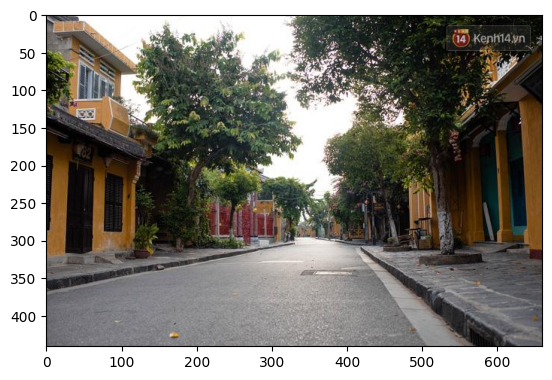

In [60]:
print(gen_caption(1,test_unique_image['image'].iloc[np.random.randint(0,100)]))

'có nhiều người đang xuất hiện bên trong khu chợ'

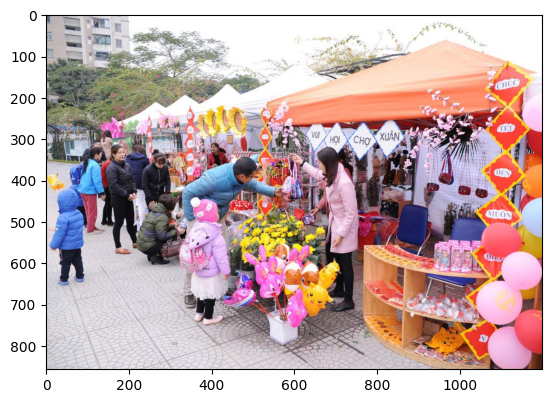

In [61]:
vidu = '/content/drive/MyDrive/EfficientNet_v2/demo.png'
gen_vidu_caption(1,vidu)


# Bleu score

In [62]:
print(len(test_unique_image))

558


In [63]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")
def score(gts_dict, res_dict):
    bleu_score = Bleu(n=4)
    bleu, _ = bleu_score.compute_score(gts=gts_dict, res=res_dict)

    rouge_scorer = Rouge()
    rouge, _ = rouge_scorer.compute_score(gts=gts_dict, res=res_dict)

    cider_scorer = Cider()
    cider, _ = cider_scorer.compute_score(gts=gts_dict, res=res_dict)

    return bleu, rouge, cider
!pip install pycocoevalcap
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 23.5 MB/s eta 0:00:00


  0%|          | 0/558 [00:00<?, ?image/s]

{'testlen': 6342, 'reflen': 6162, 'guess': [6342, 5784, 5226, 4668], 'correct': [3885, 2064, 978, 507]}
ratio: 1.0292112950339127

 ********** BLEU-4 ********** 
 [0.612582781456857, 0.46754465562250225, 0.34456557148019473, 0.2581803521718867]

 ********** ROUGH ********** 
 0.47574269501459443

 ********** CIDER (NOT CIDAr-D) ********** 
 0.6840217000791539


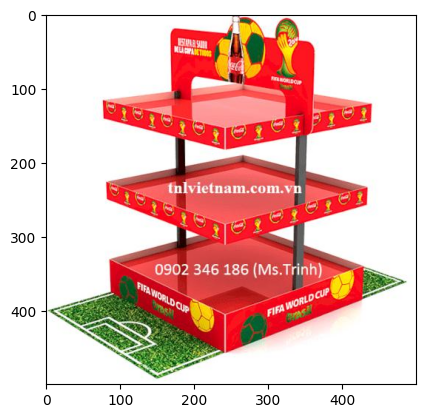

In [64]:
# captions on the validation set
# rid = np.random.randint(0, len(img_name_val))
#ref hypo
gts_dict , ref_dict = {} , {}
dem = 0
with tqdm(total=len(test_unique_image['image']) , unit = 'image') as pbar:
 for i, image_name in enumerate(test_unique_image['image']):
  # print(image_name)
  # image = valid_img_emb[image]
  # image_name = image_name[0]
  list_real_caption = [ ' '.join(i.split()[1:-2]) for i in img_path_to_caption_test[image_name]]
  # if len(list_real_caption) ==0:
  #   continue
  result = gen_caption(1, image_name)
  result = ' '.join(result[:-1])
  ref = [i.lower() for i in list_real_caption]
  test_sen = result#.split()
  # print('list_real_caption :',list_real_caption)
  # print(len(ref))
  if len(ref) == 0:
    # print('list_real_caption: ', list_real_caption)
    # print('ref' , ref)
    # print('image_path_to_caption[image_name]: ',image_path_to_caption[image_name])
    dem +=1
  else:
    # print(len(test))
    # print('test :',test)
    # print('ref :',ref)
    # print(blue_score)
    gts_dict[image_name] = ref
    ref_dict[image_name] = [test_sen]

    # blue_score_list.append(blue_score)

  # pbar.set_description(f'i =  :  {i} || BLEU score ={np.sum(blue_score_list)/len(blue_score_list)}')
  pbar.update(1)
  # break
b, r, c = score(gts_dict, ref_dict)
print('\n ********** BLEU-4 ********** \n', b)
print('\n ********** ROUGH ********** \n', r)
print('\n ********** CIDER (NOT CIDAr-D) ********** \n', c)

  # print(blue_score)